# Functional Connectivity Analysis
### Betweenness Centrality
### Mann Whitney U Test
### Circle connectivity & P-value Plots

In [2]:
import os
import mne
import sys
from mne.datasets import fetch_fsaverage
from pathlib import Path
from tabulate import tabulate
fs_dir = fetch_fsaverage(verbose=True)
subject = "fsaverage"
subjects_dir = os.path.dirname(fs_dir)
import random
sys.path.append('/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/')
from eeg_toolkit import utils, preprocess
import eeg_toolkit.functional_connectivity as fc

import power_analysis as pa
import numpy as np  
from scipy.signal import spectrogram  

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


### Paths

In [3]:
# sl_method = input("Source Localization Method (1- MNE or 2- dSPM): ")
# sl_method = 'MNE' if sl_method == '1' else 'dSPM'
# sl_method = 'dSPM'
sl_method = 'MNE'

In [4]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / f"Source Time Courses ({sl_method})"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
# subset = "FFT Permuted Data"
fc_path = data_dir / f"Functional Connectivity ({sl_method})"
fc_subset_path = fc_path / subset if subset=="FFT Permuted Data" else fc_path
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Subject IDs

In [5]:
# 1 means chronic pain, 0 means control
sub_ids = {
    '5186': 1,
    '5295': 1,
    '5648': 0,
    '5675': 0,
    '5873': 0,
    '6100': 0,
    '6106': 0,
    '6310': 1,
}

In [6]:
# Separate groups
sub_ids_LCP = {k:v for k,v in sub_ids.items() if v == 1}
sub_ids_LLP= {k:v for k,v in sub_ids.items() if v == 0}

print(f"Chronics: {len([k for k,v in sub_ids.items() if v == 1])}")
print(f"Localized: {len([k for k,v in sub_ids.items() if v == 0])}")
print(f"Total: {len(sub_ids)}")

Chronics: 3
Localized: 5
Total: 8


In [7]:
sub_ids_LCP = list(sub_ids_LCP.keys())
sub_ids_LLP = list(sub_ids_LLP.keys())

print(f"Chronics: {(sub_ids_LCP)}")
print(f"Localized: {(sub_ids_LLP)}")

Chronics: ['5186', '5295', '6310']
Localized: ['5648', '5675', '5873', '6100', '6106']


### Settings for conditions/bands/methods

In [8]:
# Settings

# Include intermediate stimulus?
include_LS = False

# Data properties
sfreq = 400  # Hz

# Use canonical bands or narrower bands
narrow_bands = True 

# Choose which connectivity estimates to run. "amplitude", "phase", or "both"
# method_choice = "phase"
method_choice = "both"

# Load previously saved group data
load_group_data_flag = False

# Save group data?
save_group_data_flag = True
   
# Evoked only or include resting too?
# include_resting = False
include_resting = True

# Orthogonalize AEC?
orthogonalize_AEC = True

#####################################################
# Test mode
plot_only_mode = True
# plot_only_mode = False
if plot_only_mode:
    # narrow_bands = False
    # include_resting = False
    load_group_data_flag = True
    save_group_data_flag = False

### Define ROIs, frequency bands, conditions, and methods for FC

In [9]:
####################################################################
# REGIONS OF INTEREST
# Get stc only from selected labels
# Get stc only from selected labels
roi_names = [# Left
             'rostralanteriorcingulate-lh', # Left Rostral ACC
             'caudalanteriorcingulate-lh', # Left Caudal ACC
             'postcentral-lh', # Left S1,
             'insula-lh', 'superiorfrontal-lh', # Left Insula, Left DL-PFC,
             'medialorbitofrontal-lh', # Left Medial-OFC
             # CONTROLS
             # lateral occipital
             'lateraloccipital-lh', # Left Visual Cortex
             'superiortemporal-lh', # Left Auditory Cortex
             # Right
             'rostralanteriorcingulate-rh', # Right Rostral ACC
             'caudalanteriorcingulate-rh', # Right Caudal ACC
             'postcentral-rh', # , Right S1
             'insula-rh', 'superiorfrontal-rh', # Right Insula, Right DL-PFC
             'medialorbitofrontal-rh', # Right Medial-OFC
             # CONTROLS
             'lateraloccipital-rh', # Right Visual Cortex
             'superiortemporal-rh', # Right Auditory Cortex
]

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "dACC-lh", "S1-lh", 
                "insula-lh", "dlPFC-lh", "mOFC-lh", 
                # CONTROLS
                "lOCC-lh", "aud-lh",
                "rACC-rh", "dACC-rh", "S1-rh", 
                "insula-rh", "dlPFC-rh", "mOFC-rh",
                # CONTROLS
                "lOCC-rh", "aud-rh", 
               ]    

####################################################################
# BANDS OF INTEREST
if not narrow_bands:
    Freq_Bands = {
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        # "alpha": [8.0, 13.0],
        # "beta": [13.0, 30.0],
        # "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        # "high-gamma": [61.5, 100.0],
    }
else:
    Freq_Bands = { # Narrower bands and overlaps
        # 'delta': [0, 4],
        "theta": [4.0, 8.0],
        "alpha": [8.0, 13.0],
        "beta": [13.0, 30.0],
        "low-gamma": [30.0, 58.5],
        # # "notch": [58.5, 61.5],
        "high-gamma": [61.5, 100.0],
    }
band_names = [band for band in Freq_Bands]

### Filter the source localized data into the canonical frequency bands

In [23]:
# Widespread Pain vs Localized Pain
these_group_names = ["Lupus with Chronic Pain"]
these_sub_ids = [sub_ids_LCP]

for this_group_name, this_sub_ids in zip(these_group_names, these_sub_ids):
    sub_power_current = {}
    print(f"Group: {this_group_name}")
    for sub_id in this_sub_ids:
        print(f"Sub: {sub_id}")               
        sub_power_current[sub_id] = {}
        for band in band_names:
            print(f"Band: {band}")
            
            data = list(zip(this_group_name, sub_id, band))  
            headers = ['Group', 'Sub', 'Band']  
            print(tabulate(data, headers, tablefmt='pretty'))  

            sub_power_current[sub_id][band] = {}
            
            # Load in source time courses
            label_ts = utils.unpickle_data(EO_resting_data_path, f"{sub_id}_eyes_open.pkl")

            # Filter with bp_gen
            minutes=5
            filtered_label_ts = pa.bp_gen(label_ts, sfreq, Freq_Bands[band][0], Freq_Bands[band][1],
                                          tmin=0,tmax=minutes*60)
            
            # Compute mean power
            mean_filtered_label_ts = np.mean(filtered_label_ts, axis=1)
            
            # Save that into dictionary
            sub_power_current[sub_id][band] = mean_filtered_label_ts
            
sub_power_LCP = sub_power_current

Group: Lupus with Chronic Pain
Sub: 5186
Band: theta
+-------+-----+------+
| Group | Sub | Band |
+-------+-----+------+
|   L   |  5  |  t   |
|   u   |  1  |  h   |
|   p   |  8  |  e   |
|   u   |  6  |  t   |
+-------+-----+------+
ts shape = (120000,)
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

ts shape = (120000,)
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

ts shape = (120000,)
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal fil

In [24]:
# Widespread Pain vs Localized Pain
these_group_names = ["Lupus with Localized Pain"]
these_sub_ids = [sub_ids_LLP]

for this_group_name, this_sub_ids in zip(these_group_names, these_sub_ids):
    sub_power_current = {}
    print(f"Group: {this_group_name}")
    for sub_id in this_sub_ids:
        print(f"Sub: {sub_id}")               
        sub_power_current[sub_id] = {}
        for band in band_names:
            print(f"Band: {band}")
            
            data = list(zip(this_group_name, sub_id, band))  
            headers = ['Group', 'Sub', 'Band']  
            print(tabulate(data, headers, tablefmt='pretty'))  

            sub_power_current[sub_id][band] = {}
            
            # Load in source time courses
            label_ts = utils.unpickle_data(EO_resting_data_path, f"{sub_id}_eyes_open.pkl")

            # Filter with bp_gen
            minutes=5
            filtered_label_ts = pa.bp_gen(label_ts, sfreq, Freq_Bands[band][0], Freq_Bands[band][1],
                                          tmin=0,tmax=minutes*60)
            
            # Compute mean power
            mean_filtered_label_ts = np.mean(filtered_label_ts, axis=1)
            
            # Save that into dictionary
            sub_power_current[sub_id][band] = mean_filtered_label_ts
            

sub_power_LLP = sub_power_current

Group: Lupus with Localized Pain
Sub: 5648
Band: theta
+-------+-----+------+
| Group | Sub | Band |
+-------+-----+------+
|   L   |  5  |  t   |
|   u   |  6  |  h   |
|   p   |  4  |  e   |
|   u   |  8  |  t   |
+-------+-----+------+
ts shape = (120000,)
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

ts shape = (120000,)
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

ts shape = (120000,)
Setting up band-pass filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal f

In [25]:
# Combine the subject level data for the two groups
group_power_LCP = {}
group_power_LLP = {}

for band in band_names:  
    all_subs_band_power = [sub_power_LCP[sub_id][band] for sub_id in sub_ids_LCP]
    
    group_power_LCP[band] = np.array(all_subs_band_power).T

for band in band_names:
    all_subs_band_power = [sub_power_LLP[sub_id][band] for sub_id in sub_ids_LLP]
    
    group_power_LLP[band] = np.array(all_subs_band_power).T

## Compute statistics to assess statistical differences 

### Mean

In [26]:
from scipy.stats import mannwhitneyu  
  
for band in band_names:
    for i in range(len(roi_acronyms)):
        
        power_group1 = group_power_LCP[band][i]
        power_group2 = group_power_LLP[band][i]
                
        # perform the Mann-Whitney U test
        _, p_val = mannwhitneyu(power_group1, power_group2) 
        
        # Only print significant results
        if p_val < 0.05:
            print(f"{band.upper()}\n{roi_acronyms[i]}")

            # print the means
            print(f"Lupus Chronic Pain mean = {np.round(np.mean(power_group1),13)}")
            print(f"Lupus Localized Pain mean = {np.round(np.mean(power_group2),13)}")
            
            print(f"p-val = {np.round(p_val,4)}\n")

THETA
dACC-rh
Lupus Chronic Pain mean = -1.397e-10
Lupus Localized Pain mean = 1.252e-10
p-val = 0.0357

THETA
mOFC-rh
Lupus Chronic Pain mean = -6.81e-11
Lupus Localized Pain mean = 1.635e-10
p-val = 0.0357

THETA
aud-rh
Lupus Chronic Pain mean = -2.7e-12
Lupus Localized Pain mean = 8.08e-11
p-val = 0.0357

ALPHA
S1-lh
Lupus Chronic Pain mean = 3.95e-11
Lupus Localized Pain mean = -8e-12
p-val = 0.0357

BETA
aud-rh
Lupus Chronic Pain mean = -8.3e-12
Lupus Localized Pain mean = 1.55e-11
p-val = 0.0357

HIGH-GAMMA
lOCC-lh
Lupus Chronic Pain mean = -9.9e-12
Lupus Localized Pain mean = 2.6e-12
p-val = 0.0357

HIGH-GAMMA
aud-rh
Lupus Chronic Pain mean = 3.2e-12
Lupus Localized Pain mean = -2.3e-12
p-val = 0.0357



### Absolute value of Mean

THETA
S1-lh
Lupus Chronic Pain mean = 1.001e-10
Lupus Localized Pain mean = 1.41e-11
p-val = 0.0357



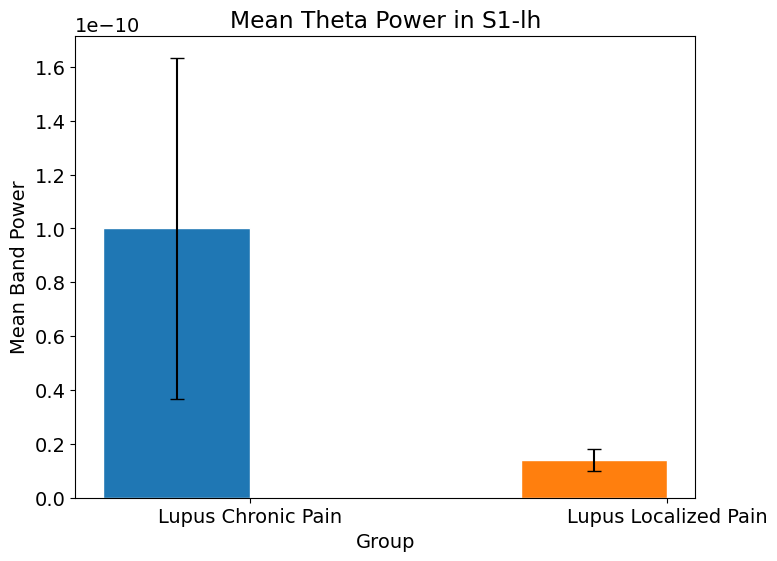

ALPHA
rACC-lh
Lupus Chronic Pain mean = 4.42e-11
Lupus Localized Pain mean = 1.481e-10
p-val = 0.0357



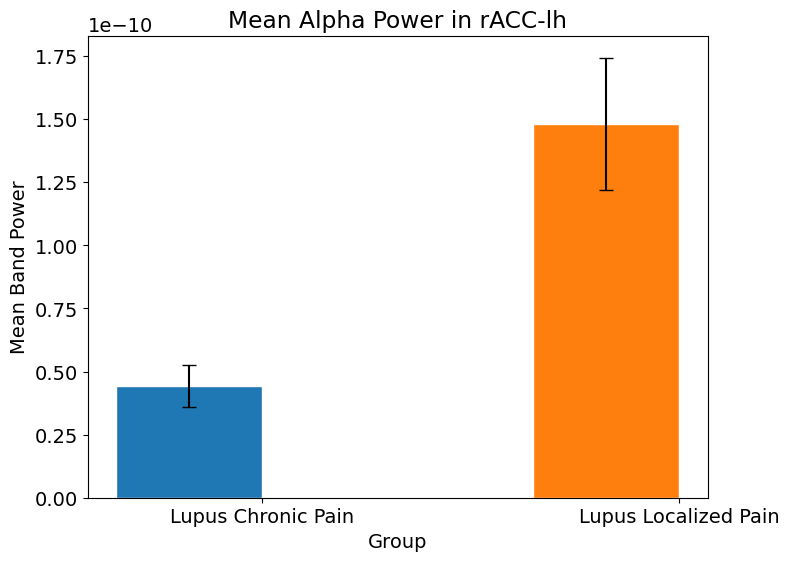

ALPHA
rACC-rh
Lupus Chronic Pain mean = 3.14e-11
Lupus Localized Pain mean = 1.198e-10
p-val = 0.0357



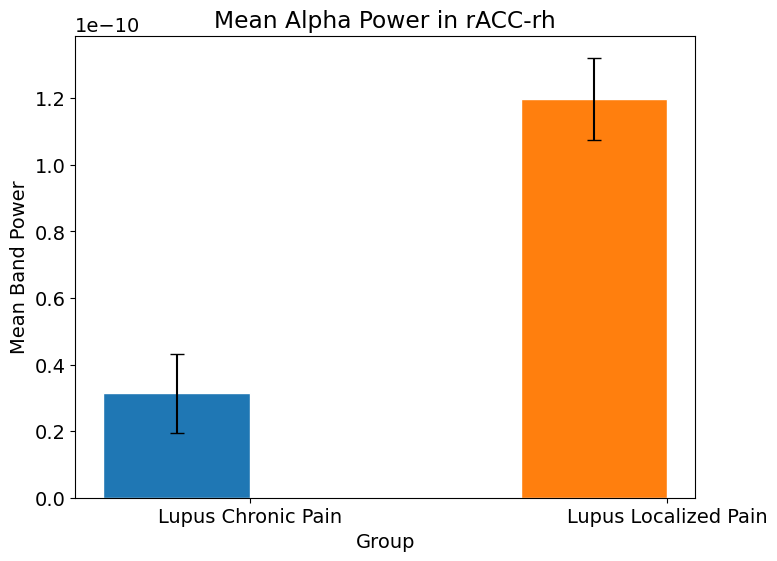

LOW-GAMMA
dACC-lh
Lupus Chronic Pain mean = 9.8e-12
Lupus Localized Pain mean = 4.14e-11
p-val = 0.0357



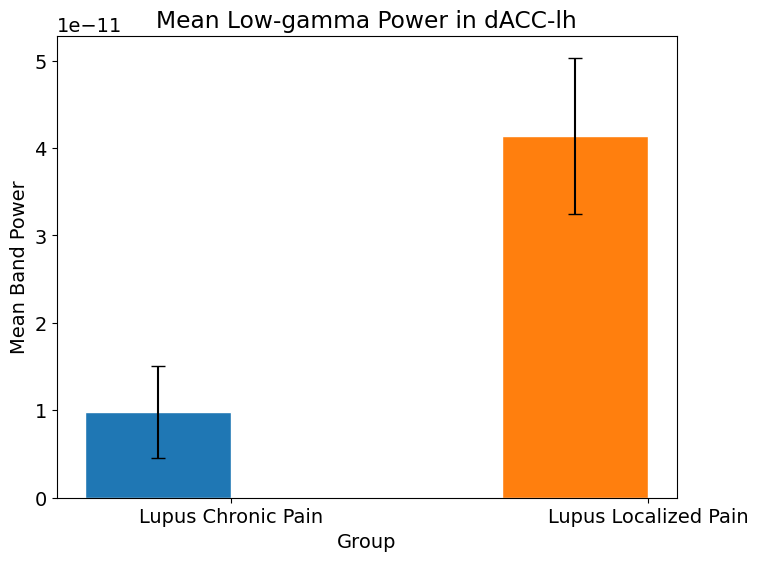

LOW-GAMMA
lOCC-lh
Lupus Chronic Pain mean = 3e-12
Lupus Localized Pain mean = 1.16e-11
p-val = 0.0357



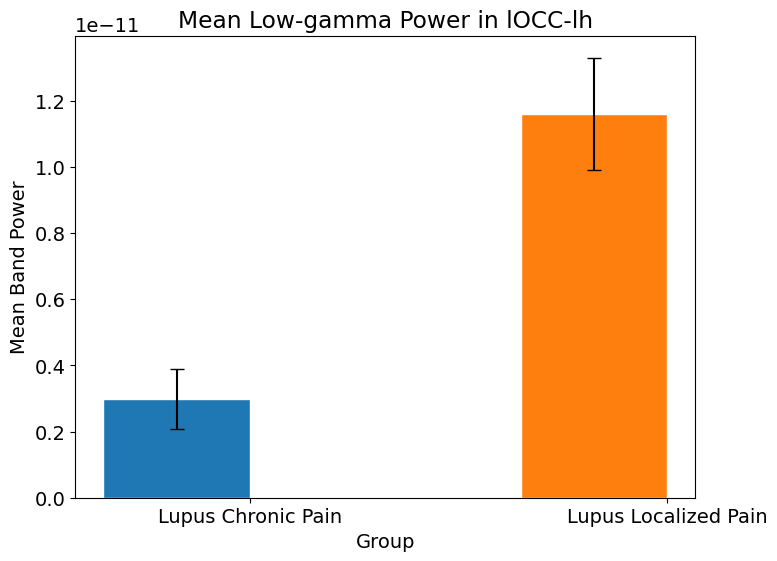

In [46]:
from scipy.stats import mannwhitneyu   
from scipy import stats  
import numpy as np  
import matplotlib.pyplot as plt   
    
for band in band_names:  
    for i in range(len(roi_acronyms)):  
          
        power_group1 = np.abs(group_power_LCP[band][i])  
        power_group2 = np.abs(group_power_LLP[band][i])  
                  
        # perform the Mann-Whitney U test  
        _, p_val = mannwhitneyu(power_group1, power_group2)   
          
        # Only print significant results  
        if p_val < 0.05:  
              
            print(f"{band.upper()}\n{roi_acronyms[i]}")  
  
            # print the means  
            print(f"Lupus Chronic Pain mean = {np.round(np.mean(power_group1),13)}")  
            print(f"Lupus Localized Pain mean = {np.round(np.mean(power_group2),13)}")  
              
            print(f"p-val = {np.round(p_val,4)}\n")  
              
            # Get the means and standard errors  
            means_LCP = np.mean(power_group1, axis=0)  
            se_LCP = stats.sem(power_group1, axis=0)  
              
            means_LLP = np.mean(power_group2, axis=0)  
            se_LLP = stats.sem(power_group2, axis=0)  
              
            # Set the figure size and font size    
            plt.figure(figsize=(8,6))    
            plt.rcParams.update({'font.size': 14})    
              
            # Set the bar width and position    
            bar_width = 0.35    
            r1 = np.arange(2)    
            r2 = [x + bar_width for x in r1]    
              
            # Set colors
            colors = ['#1f77b4', '#ff7f0e']  

            # Plot the bars and error bars    
            plt.bar(r1, [means_LCP, means_LLP], width=bar_width, edgecolor='white', yerr=[se_LCP, se_LLP], capsize=5, color=colors)
            
            # Add labels and title    
            plt.xlabel('Group')    
            plt.ylabel('Mean Band Power')    
            plt.title(f'Mean {band.capitalize()} Power in {roi_acronyms[i]}')    
              
            # Add x-axis tick labels    
            plt.xticks([r + bar_width/2 for r in range(2)], ['Lupus Chronic Pain', 'Lupus Localized Pain'])    
              
            # Show the plot    
            plt.show()    


## Plot above results

# Try with power envelope instead

### Filter the source localized data into the canonical frequency bands

In [15]:
from scipy.signal import hilbert

In [21]:
# # Widespread Pain vs Localized Pain
# these_group_names = ["Lupus with Chronic Pain"]
# these_sub_ids = [sub_ids_LCP]

# for this_group_name, this_sub_ids in zip(these_group_names, these_sub_ids):
#     sub_power_current = {}
#     print(f"Group: {this_group_name}")
#     for sub_id in this_sub_ids:
#         print(f"Sub: {sub_id}")               
#         sub_power_current[sub_id] = {}
#         for band in band_names:
#             print(f"Band: {band}")
            
#             data = list(zip(this_group_name, sub_id, band))  
#             headers = ['Group', 'Sub', 'Band']  
#             print(tabulate(data, headers, tablefmt='pretty'))  

#             sub_power_current[sub_id][band] = {}
            
#             # Load in source time courses
#             label_ts = utils.unpickle_data(EO_resting_data_path, f"{sub_id}_eyes_open.pkl")

#             # Filter with bp_gen
#             minutes=5
            
#             filtered_label_ts = pa.bp_gen(label_ts, sfreq, Freq_Bands[band][0], Freq_Bands[band][1],
#                                           tmin=0,tmax=minutes*60)
            
#             # Apply Hilbert transform to get analytic signal  
#             analytic_signal = hilbert(filtered_label_ts)  
        
#             # Compute power envelope  
#             power_envelope = np.abs(analytic_signal)
        
#             # Compute mean power envelope  
#             mean_power_envelope = np.mean(power_envelope, axis=1)  
        
#             # Save that into dictionary  
#             sub_power_current[sub_id][band] = mean_power_envelope 
           
#             # Save that into dictionary
#             sub_power_current[sub_id][band] = mean_filtered_label_ts
            
# sub_power_LCP = sub_power_current

In [22]:
# # Widespread Pain vs Localized Pain
# these_group_names = ["Lupus with Localized Pain"]
# these_sub_ids = [sub_ids_LLP]

# for this_group_name, this_sub_ids in zip(these_group_names, these_sub_ids):
#     sub_power_current = {}
#     print(f"Group: {this_group_name}")
#     for sub_id in this_sub_ids:
#         print(f"Sub: {sub_id}")               
#         sub_power_current[sub_id] = {}
#         for band in band_names:
#             print(f"Band: {band}")
            
#             data = list(zip(this_group_name, sub_id, band))  
#             headers = ['Group', 'Sub', 'Band']  
#             print(tabulate(data, headers, tablefmt='pretty'))  

#             sub_power_current[sub_id][band] = {}
            
#             # Load in source time courses
#             label_ts = utils.unpickle_data(EO_resting_data_path, f"{sub_id}_eyes_open.pkl")

#             # Filter with bp_gen
#             minutes=5
            
#             filtered_label_ts = pa.bp_gen(label_ts, sfreq, Freq_Bands[band][0], Freq_Bands[band][1],
#                                           tmin=0,tmax=minutes*60)
            
#             # Apply Hilbert transform to get analytic signal  
#             analytic_signal = hilbert(filtered_label_ts)  
        
#             # Compute power envelope  
#             power_envelope = np.abs(analytic_signal)
        
#             # Compute mean power envelope  
#             mean_power_envelope = np.mean(power_envelope, axis=1)  
        
#             # Save that into dictionary  
#             sub_power_current[sub_id][band] = mean_power_envelope 
           
#             # Save that into dictionary
#             sub_power_current[sub_id][band] = mean_filtered_label_ts
            
# sub_power_LLP = sub_power_current

In [18]:
# Combine the subject level data for the two groups
group_power_LCP = {}
group_power_LLP = {}

for band in band_names:  
    all_subs_band_power = [sub_power_LCP[sub_id][band] for sub_id in sub_ids_LCP]
    
    group_power_LCP[band] = np.array(all_subs_band_power).T

for band in band_names:
    all_subs_band_power = [sub_power_LLP[sub_id][band] for sub_id in sub_ids_LLP]
    
    group_power_LLP[band] = np.array(all_subs_band_power).T

## Compute statistics to assess statistical differences 

### Mean

In [19]:
from scipy.stats import mannwhitneyu  
  
for band in band_names:
    for i in range(len(roi_acronyms)):
        
        power_group1 = group_power_LCP[band][i]
        power_group2 = group_power_LLP[band][i]
                
        # perform the Mann-Whitney U test
        _, p_val = mannwhitneyu(power_group1, power_group2) 
        
        # Only print significant results
        if p_val < 0.05:
            print(f"{band.upper()}\n{roi_acronyms[i]}")

            # print the means
            print(f"Group 1 mean = {np.round(np.mean(power_group1),13)}")
            print(f"Group 2 mean = {np.round(np.mean(power_group2),13)}")
            
            print(f"p-val = {np.round(p_val,4)}\n")